First of all, the necessary libraries:

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import json
import PIL
from PIL import ImageDraw, ImageFont,Image, ImageOps, ImageEnhance
from matplotlib import patches, patheffects
import numpy as np
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision import transforms,models
from torchvision.utils import make_grid
import math
import random
import numbers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm, tqdm_notebook
import glob
from skimage import io
from torch.autograd import Variable as V
from scipy import ndimage
import time
import os
import copy
import skimage
torch.backends.cudnn.benchmark=True
torch.cuda.set_device(0)
import scipy
def sum_geom(a,r,n): return a*n if r==1 else math.ceil(a*(1-r**n)/(1-r))
def is_listy(x): return isinstance(x, (list,tuple))
def is_iter(x): return isinstance(x, collections.Iterable)
def map_over(x, f): return [f(o) for o in x] if is_listy(x) else f(x)
def map_none(x, f): return None if x is None else f(x)
def delistify(x): return x[0] if is_listy(x) else x
def listify(x, y):
    if not is_iter(x): x=[x]
    n = y if type(y)==int else len(y)
    if len(x)==1: x = x * n
    return x

def datafy(x):
    if is_listy(x): return [o.data for o in x]
    else:           return x.data

conv_dict = {np.dtype('int8'): torch.LongTensor, np.dtype('int16'): torch.LongTensor,
    np.dtype('int32'): torch.LongTensor, np.dtype('int64'): torch.LongTensor,
    np.dtype('float32'): torch.FloatTensor, np.dtype('float64'): torch.FloatTensor}

def A(*a):
    """convert iterable object into numpy array"""
    return np.array(a[0]) if len(a)==1 else [np.array(o) for o in a]

def T(a, half=False, cuda=True):
    """
    Convert numpy array into a pytorch tensor. 
    if Cuda is available and USE_GPU=True, store resulting tensor in GPU.
    """
    if not torch.is_tensor(a):
        a = np.array(np.ascontiguousarray(a))
        if a.dtype in (np.int8, np.int16, np.int32, np.int64):
            a = torch.LongTensor(a.astype(np.int64))
        elif a.dtype in (np.float32, np.float64):
            a = to_half(a) if half else torch.FloatTensor(a)
        else: raise NotImplementedError(a.dtype)
    if cuda: a = to_gpu(a)
    return a

def to_half(tensor):
    if torch.cuda.is_available():
        return torch.cuda.HalfTensor(tensor)
    else:
        return torch.FloatTensor(tensor)

def create_variable(x, volatile, requires_grad=False):
    if type (x) != Variable:
        x = Variable(T(x), requires_grad=requires_grad, volatile=volatile)
    return x

def V_(x, requires_grad=False, volatile=False):
    '''equivalent to create_variable, which creates a pytorch tensor'''
    return create_variable(x, volatile=volatile, requires_grad=requires_grad)
def V(x, requires_grad=False, volatile=False):
    '''creates a single or a list of pytorch tensors, depending on input x. '''
    return map_over(x, lambda o: V_(o, requires_grad, volatile))

def VV_(x): 
    '''creates a volatile tensor, which does not require gradients. '''
    return create_variable(x, True)

def VV(x):
    '''creates a single or a list of pytorch tensors, depending on input x. '''
    return map_over(x, VV_)

def to_np(v):
    '''returns an np.array object given an input of np.array, list, tuple, torch variable or tensor.'''
    if isinstance(v, float): return np.array(v)
    if isinstance(v, (np.ndarray, np.generic)): return v
    if isinstance(v, (list,tuple)): return [to_np(o) for o in v]
    if isinstance(v, Variable): v=v.data
    if torch.cuda.is_available():
        if is_half_tensor(v): v=v.float()
    if isinstance(v, torch.FloatTensor): v=v.float()
    return v.cpu().numpy()

def is_half_tensor(v):
    return isinstance(v, torch.cuda.HalfTensor)


USE_GPU = torch.cuda.is_available()
def to_gpu(x, *args, **kwargs):
    '''puts pytorch variable to gpu, if cuda is available and USE_GPU is set to true. '''
    return x.cuda(*args, **kwargs) if USE_GPU else x

def noop(*args, **kwargs): return

def trainable_params_(m):
    '''Returns a list of trainable parameters in the model m. (i.e., those that require gradients.)'''
    return [p for p in m.parameters() if p.requires_grad]

def chain_params(p):
    if is_listy(p):
        return list(chain(*[trainable_params_(o) for o in p]))
    return trainable_params_(p)

def set_trainable_attr(m,b):
    m.trainable=b
    for p in m.parameters(): p.requires_grad=b

def apply_leaf(m, f):
    c = children(m)
    if isinstance(m, nn.Module): f(m)
    if len(c)>0:
        for l in c: apply_leaf(l,f)
def children(m): return m if isinstance(m, (list, tuple)) else list(m.children())
def set_trainable(l, b):
    apply_leaf(l, lambda m: set_trainable_attr(m,b))


In [3]:
PATH = Path('dataSet/')

Grab the training and the test set.

In [4]:
trn_set = datasets.MNIST(PATH, train=True, download=True)
tst_set = datasets.MNIST(PATH, train=False, download=True)

Let's have a look at the data in the training set first.

In [5]:
len(trn_set.train_data), len(tst_set.test_data)

(60000, 10000)

Each image is represented by a tensor of size 28 by 28, each value represents the color of the corresponding pixel, from 0 (black) to 255 (white). Torch tensors are the equivalent of numpy ndarrays.

It's easy to convert a torch tensor to a numpy array via the .numpy() command.

Conversely, you can create a torch Tensor from a numpy array x via torch.Tensor(x)

It's then easy to see the corresponding picture via plt.

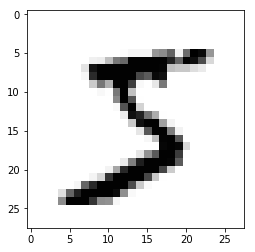

In [6]:
plt.imshow(trn_set.train_data[0].numpy(), cmap='Greys')

Let's have a look at the corresponding label...

In [7]:
trn_set.train_labels[0]

tensor(5)

# Preparing the data

In [8]:
tsfms = transforms.ToTensor()
trn_set = datasets.MNIST(PATH, train=True, download=True, transform=tsfms)
tst_set = datasets.MNIST(PATH, train=False, download=True, transform=tsfms)

In [9]:
trn_loader = torch.utils.data.DataLoader(trn_set, batch_size=64, shuffle=True, num_workers=0)
tst_loader = torch.utils.data.DataLoader(tst_set, batch_size=64, shuffle=False, num_workers=0)

Let's have a look at an example. A data loader can be converted into an iterator and we can then ask him for a minibatch.

In [10]:
mb_example = next(iter(trn_loader))

In [11]:
mb_example[0].size(), mb_example[1].size()

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [12]:
mean = torch.mean(trn_set.train_data.type(torch.FloatTensor))/255.
std = torch.std(trn_set.train_data.type(torch.FloatTensor))/255.
mean,std

(tensor(0.1306), tensor(0.3081))

We divide by 255 to get the means of our data when it's convereted into floats from 0. to 1.

Then we go back to creating a transfrom and add the normalization. Note that we use the same mean and std for the test set. Afterward, we reload our datasets, adding this transform.

In [13]:
tsfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])
trn_set = datasets.MNIST(PATH, train=True, download=True, transform=tsfms)
tst_set = datasets.MNIST(PATH, train=False, download=True, transform=tsfms)

In [14]:
trn_loader = torch.utils.data.DataLoader(trn_set, batch_size=64, shuffle=True, num_workers=0)
tst_loader = torch.utils.data.DataLoader(tst_set, batch_size=64, shuffle=False, num_workers=0)

# Create a model

In [15]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.linear1 = nn.Linear(n_in, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_out)
    
    def forward(self,x):
        x = x.view(x.size(0),-1)
        x = F.relu(self.linear1(x))
        return F.log_softmax(self.linear2(x), dim=-1)

In [16]:
net = SimpleNeuralNet(28*28,100,10).cuda()
optimizer = optim.SGD(net.parameters(),lr=1e-2)

In [17]:
def train(nb_epoch):
    for epoch in range(nb_epoch):
        running_loss = 0.
        corrects = 0
        print(f'Epoch {epoch+1}:')
        for data in trn_loader:
            inputs,labels = data
            inputs, labels = V(inputs), V(labels)
            optimizer.zero_grad()
            outputs = net(inputs)
            _,preds = torch.max(outputs.data,1)
            loss = F.nll_loss(outputs, labels)
            running_loss += loss.data.item() * inputs.size(0)
            corrects += torch.sum(labels.data == preds.cuda())
            loss.backward()
            optimizer.step()
        print(f'Loss: {running_loss/len(trn_set)}  Accuracy: {100.*corrects/len(trn_set)}')

Now we're ready to train our model.

In [18]:
train(5)

Epoch 1:
Loss: 0.5788133769432704  Accuracy: 85
Epoch 2:
Loss: 0.3013044168869654  Accuracy: 91
Epoch 3:
Loss: 0.2546365159193675  Accuracy: 92
Epoch 4:
Loss: 0.22325895236333212  Accuracy: 93
Epoch 5:
Loss: 0.19944103789726894  Accuracy: 94


94% accuracy is good, but that's on the training set and we may be overfitting. Let's try on the test set now to see if we're doing well or not.

In [19]:
def validate():
    running_loss = 0.
    corrects = 0
    for data in tst_loader:
        inputs,labels = data
        inputs, labels = V(inputs), V(labels)
        outputs = net(inputs)
        _,preds = torch.max(outputs.data,1)
        loss = F.nll_loss(outputs, labels)
        running_loss += loss.data.item() * inputs.size(0)
        corrects += torch.sum(labels.data == preds.cuda())
    print(f'Loss: {running_loss/len(tst_set)}  Accuracy: {100.*corrects/len(tst_set)}')

In [20]:
validate()

Loss: 0.18535682628154754  Accuracy: 94


So we weren't overfitting!

# Learning rate finder

In [21]:
def find_lr(init_value = 1e-8, final_value=10., beta = 0.98):
    num = len(trn_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data in trn_loader:
        batch_num += 1
        inputs,labels = data
        inputs, labels = V(inputs), V(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        avg_loss = beta * avg_loss + (1-beta) *loss.data.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        loss.backward()
        optimizer.step()
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

Now we can define our neural net as before.

In [22]:
net = SimpleNeuralNet(28*28,100,10).cuda()
optimizer = optim.SGD(net.parameters(),lr=1e-1)
criterion = F.nll_loss

Then plot the losses versus the logs of the learning rate

In [23]:
logs,losses = find_lr()

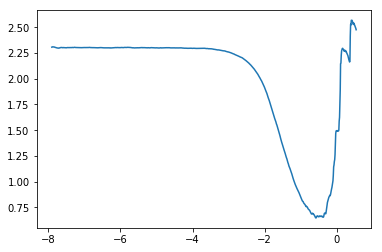

In [24]:
plt.plot(logs[10:-5],losses[10:-5])

This suggests the best learning rate is $10^{-1}$ so we can use test this one after defining a new network.

In [25]:
net = SimpleNeuralNet(28*28,100,10).cuda()
optimizer = optim.SGD(net.parameters(),lr=1e-1)
train(1)

Epoch 1:
Loss: 0.2584514814933141  Accuracy: 92


In [26]:
train(4)

Epoch 1:
Loss: 0.11329360496997833  Accuracy: 96
Epoch 2:
Loss: 0.08071397163073221  Accuracy: 97
Epoch 3:
Loss: 0.06354744155009588  Accuracy: 98
Epoch 4:
Loss: 0.051555388816197714  Accuracy: 98


We are already at 92% accuracy when the learning rate used before gave us 85% in one epoch!

# CNN

In [27]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
    
class Flatten(nn.Module):
    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

In [28]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [29]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [30]:
net = ConvBnNet([10, 20, 40,80,160], 10)
net = nn.DataParallel(net, device_ids=None)
optimizer = optim.SGD(net.parameters(),lr=1e-1)
criterion = F.nll_loss

In [31]:
train(1)

Epoch 1:
Loss: 0.11037411624590555  Accuracy: 96


initially we got an accuracy of 85% using simple neural net then we use learning rate finder and we got an accuracy of 92% in one epoch and using CNN and batch norm we got an accuracy of 96% in one epoch  

In [32]:
train(4)

Epoch 1:
Loss: 0.03743914530674616  Accuracy: 98
Epoch 2:
Loss: 0.02325316725174586  Accuracy: 99
Epoch 3:
Loss: 0.015216404219468434  Accuracy: 99
Epoch 4:
Loss: 0.009684098033110301  Accuracy: 99


In [33]:
validate()

Loss: 0.03032072174549103  Accuracy: 98


we are having good accuracy on training set and validation set ie 99%